## Import necessary libraries

In [1]:
import numpy as np
from PIL import Image
import torch
from torchvision import transforms, datasets
from scipy.stats import multivariate_normal
from IPython.display import display
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (4, 4)
%matplotlib inline 

# Task 1: Simple Image Operations

### 1. Load image

In [2]:
image_path = './data/capybara.jpg' 
img = Image.open(image_path)

### 2. Print width, height, and number of channels and plot the image

In [3]:
# print the image size
print(f"width: {img.width}, height: {img.height}, channel: {len(img.getbands())}")

width: 800, height: 600, channel: 3


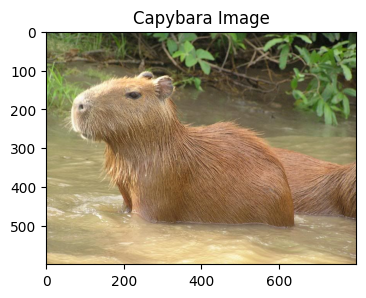

In [4]:
# plot the image
plt.title('Capybara Image') 
plt.imshow(img)

### 3. Crop a random patch of size 256x256 from the image

In [5]:
def get_random_crop(image, crop_height, crop_width):
    width, height = image.size

    max_x = width - crop_width
    max_y = height - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image.crop((x, y, x + crop_width, y + crop_height))

    return crop, x, y

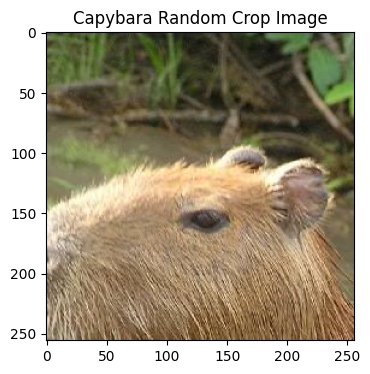

In [6]:
# crop random patch of 256x256
random_crop_size = 256
random_crop, random_crop_x, random_crop_y = get_random_crop(img, random_crop_size, random_crop_size)

# plot the cropped image
plt.title('Capybara Random Crop Image') 
plt.imshow(random_crop)

### 4. Convert the image patch to grayscale

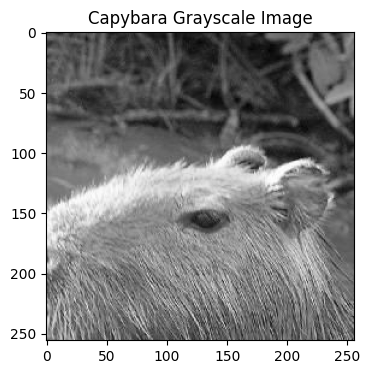

In [7]:
# convert to grayscale
random_crop_gray = transforms.Grayscale()(random_crop)

# plot the grayscale image
plt.title('Capybara Grayscale Image')
plt.imshow(random_crop_gray , cmap='gray')

### 5. Insert the grayscale patch back into the original image

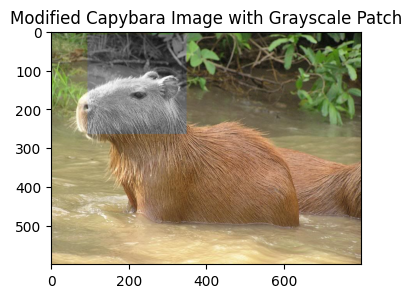

In [8]:
# convert to numpy array
img_np = np.array(img)
random_crop_gray_np = np.array(random_crop_gray)

# insert grayscale image back into original image
img_np[random_crop_y:random_crop_y + random_crop_size, random_crop_x:random_crop_x + random_crop_size] = np.stack((random_crop_gray_np,) * 3, axis=-1)

# convert the modified numpy array back to a PIL Image
modified_img = Image.fromarray(img_np)

# plot the modified image
plt.title('Modified Capybara Image with Grayscale Patch')
plt.imshow(modified_img)
plt.show()

### 6. Resize the image with the inserted gray patch 

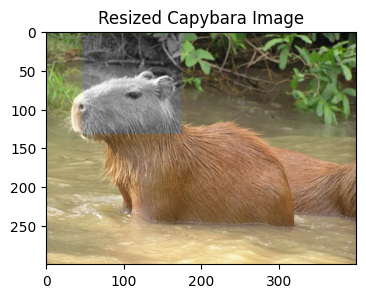

In [9]:
# resize modified image to 50% of original size
scale = 0.5
resized_img = modified_img.resize((int(modified_img.width * scale), int(modified_img.height * scale)))

# plot the resized image
plt.title('Resized Capybara Image')
plt.imshow(resized_img)

# Task 2: Convolution and Filters

### Utils
take care of the range of the value before plot the images

In [10]:
def display_img(x, norm=False):
    """
    Displays image
    """
    x = np.copy(x)
    # Normalize if necessary
    if norm:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
    # Scale and convert to uint8 format for PIL plotting
    x *= 255
    x = x.astype(np.uint8)
    # Handle channel dimension
    if len(x.shape) == 2:
        x = x[:, :, np.newaxis]
    if x.shape[2] == 1:
        x = np.repeat(x, 3, axis=2)

    display(Image.fromarray(x))

def load_img(path, grayscale=False):
    """
    Loads image from given path, converts to float and normalize to [0,1] interval
    """
    img = Image.open(path)
    a = np.asarray(img, dtype=np.float32) / 255
    # Convert to grayscale if necessary
    if grayscale:
        a = np.mean(a, axis=2, keepdims=True)
    return a

### 1. Implement convolution operation

In [11]:
def conv2d(image: np.array, kernel: np.array):
    """
    Performs 2D convolution operation with a single kernel.

    Args:
        image  (array): the input array of shape (H, W, 1).
        kernel (array): the kernel that is convolved over the input.

    Returns:
        out    (array): the output array.
    """
    if kernel.ndim == 2:
        kernel = kernel[np.newaxis, :, :]

    kernel_height, kernel_width, _ = kernel.shape
    _, _, num_channels = image.shape

    output_height = image.shape[0] - kernel_height + 1
    output_width = image.shape[1] - kernel_width + 1

    result = np.zeros((output_height, output_width, num_channels)).astype(np.float32)

    for channel in range(num_channels):
        for i in range(output_height):
            for j in range(output_width):
                result[i][j][channel] = np.sum(image[i:i + kernel_height, j:j + kernel_width, channel] * kernel[:, :, 0]).astype(np.float32)
    return result

### 2. Implement a Gaussian filter

In [12]:
def gaussian_filter(size, mean=0, var=1) -> np.ndarray:
    """
    Returns an isotropic Gaussian filter with.
    
    Args:
        size       (int): the size of the kernel.
        mean (float/int): the mean of the Gaussian.
        var  (float/int): the variance of the Gaussian.

    Returns:
        f        (array): the Gaussian filter of shape (size, size, 1).
    """
    x = np.linspace(-size // 2, size // 2, size)
    y = x[:, np.newaxis]

    gaussian = (1 / (np.sqrt(2 * np.pi * var))) * np.exp(-((x ** 2 + y ** 2) / (2 * var)))

    # Normalize the filter
    gaussian /= np.sum(gaussian)

    # Add the mean (if non-zero)
    if mean != 0:
        gaussian += mean

    # Add a new axis to make the filter have shape (size, size, 1)
    gaussian = gaussian[:, :, np.newaxis]

    return gaussian

In [13]:
f = gaussian_filter(size=200, mean=0, var=1000)

print(f"Filter shape: {f.shape}")

Filter shape: (200, 200, 1)


In [14]:
sum = np.sum(f)
print(sum)

1.0


Gaussian filter:


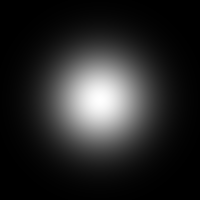

In [15]:
print('Gaussian filter:')
display_img(f, norm=True)

### 3. Apply Gaussian filter to image

Original image:


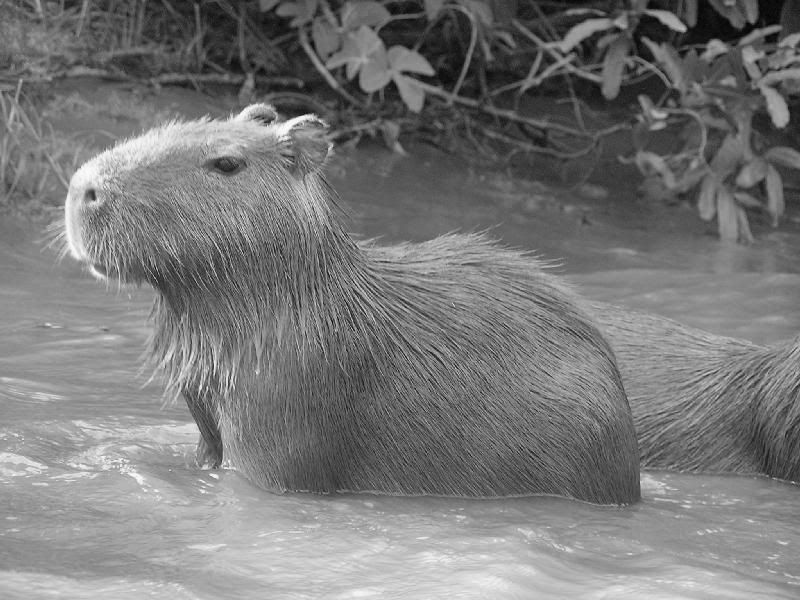

In [16]:
# apply the filter to the image
img = load_img(image_path, grayscale=True)
array = np.array(img)

print('Original image:')
display_img(array)

In [17]:
filter_size = (200, 200) 
mean = 0
variance = 100

# obtain the Gaussian filter
f = gaussian_filter(size=filter_size[0], mean=mean, var=variance) 

print(f"Gaussian filter shape: {f.shape}")
print(f"Image array shape: {array.shape}")

Gaussian filter shape: (200, 200, 1)
Image array shape: (600, 800, 1)


Gaussian filtered image:


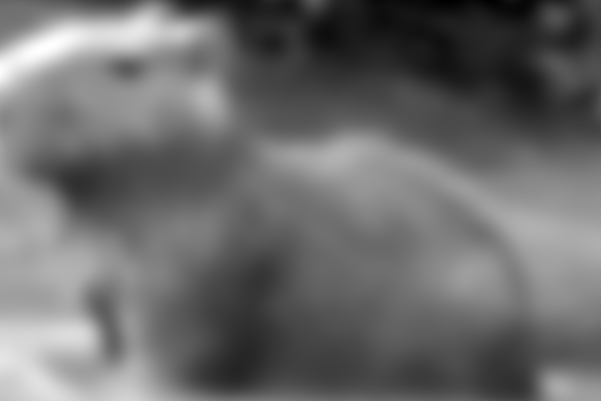

In [18]:
# normalize the image by dividing 255
array_norm = array / 255

# perform 2D convolution
array_filtered = conv2d(array_norm, f)

# normalize the filtered image by dividing 255
array_filtered /= 255
# scale the image to [0, 255]
array_filtered = (array_filtered - np.min(array_filtered)) / (np.max(array_filtered) - np.min(array_filtered))

print('Gaussian filtered image:')
display_img(array_filtered)

### 4. Implement and apply Laplacian filter to image

Hint: If you only apply laplacian and use plt to plot without taking care of the value range, you would probably have a hard time to see something

In [19]:
# implement the Laplacian filter
def laplace_filter(size: int):
    """
    Returns a Laplacian filter of a specified size.

    Args:
        size (int): the size of the kernel (assumed to be odd).

    Returns:e
        f (array): the Laplacian filter of shape (size, size).
    """
    # odd sizes only
    if size % 2 == 0:
        size += 1

    mid = size // 2
    laplacian = np.zeros((size, size))
    laplacian[mid, mid] = -(size**2 - 4)

    for i in range(size):
        for j in range(size):
            if i != mid and j != mid:
                laplacian[i, j] = 1

    return laplacian

In [20]:
# obtain the Laplacian filter
laplacian_filter = laplace_filter(size=5)

print(f"Laplacian filter shape: {laplacian_filter.shape}")

Laplacian filter shape: (5, 5)


Original image:


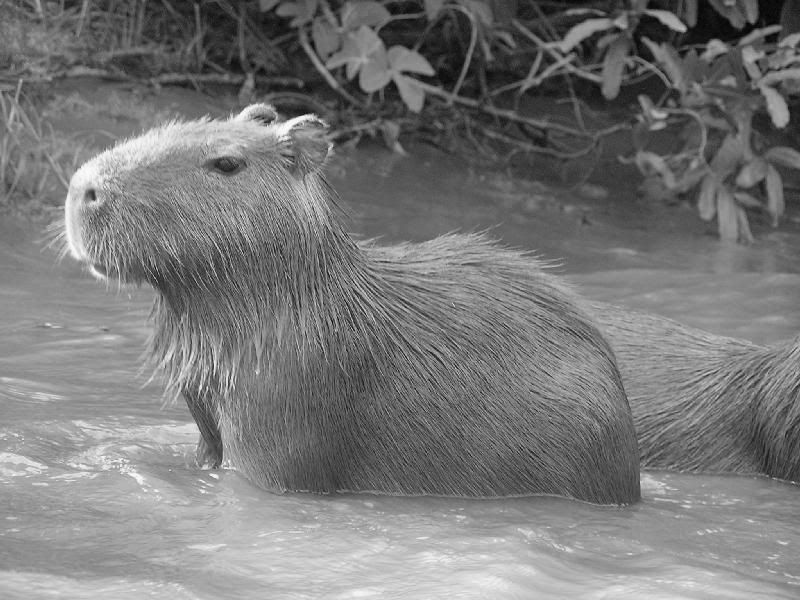

In [21]:
print('Original image:')
display_img(array)

Laplacian filtered image:


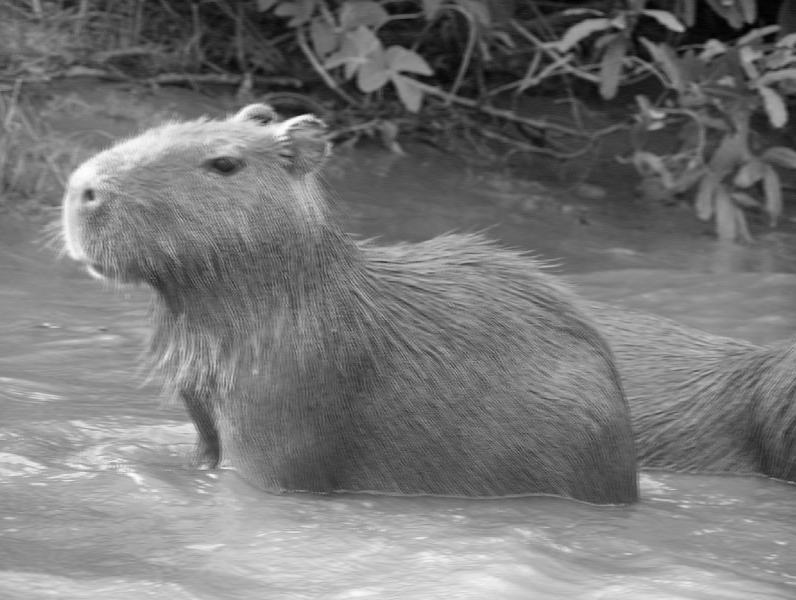

In [22]:
# normalize the image by dividing 255
array_norm = array / 255

# apply the Laplacian filter to the image
array_filtered = conv2d(array_norm, laplacian_filter)

# normalize the filtered image by dividing 255
array_filtered /= 255
# scale the image to [0, 255]
array_filtered = (array_filtered - np.min(array_filtered)) / (np.max(array_filtered) - np.min(array_filtered))

print('Laplacian filtered image:')
display_img(array_filtered)

### 5. Problems with handcrafted filters

Hand-crafted filters have limitations, such as limited adaptability, as they are designed for specific features or patterns like edges, corners, or textures, which might not be suitable for the actual patterns in the input data, leading to suboptimal performance. They also require domain expertise and effort to design, which can be time-consuming and costly. Additionally, hand-crafted filters primarily focus on extracting low-level features and may not capture high-level salient features as effectively as learned filters, which are better in learning hierarchical representations of the data.

# Task 3: Introduction to PyTorch

### 1. Convert NumPy array to PyTorch tensor and vice versa

In [23]:
# convert the image to a PyTorch tensor
x = torch.from_numpy(array)

print(f"Shape of tensor: {x.shape}")

Shape of tensor: torch.Size([600, 800, 1])


In [24]:
# swap the axes to match the PyTorch format
x = x.permute(2, 0, 1)

print(f"Shape of tensor: {x.shape}")

Shape of tensor: torch.Size([1, 600, 800])


In [25]:
# swap back the axes to match the original format
x = x.permute(1, 2, 0)

print(f"Shape of tensor: {x.shape}")

Shape of tensor: torch.Size([600, 800, 1])


In [26]:
# convert the tensor back to a numpy array
array = x.numpy()

print(f"Shape of array: {array.shape}")

Shape of array: (600, 800, 1)


### 2. Create a PyTorch convolution operator

In [27]:
# create random array for image and kernel
X = np.random.rand(5,5,1)
W = np.random.rand(2,2,1)

print(f"Shape of X: {X.shape}")
print(f"Shape of W: {W.shape}")

Shape of X: (5, 5, 1)
Shape of W: (2, 2, 1)


In [28]:
# convert x,w to PyTorch tensors / swap axes
X_i = torch.from_numpy(X)
X_i = X_i.permute(2,0,1)

W_i = torch.from_numpy(W)
W_i = W_i.permute(2,0,1)

print(f"Shape of tensor: {X_i.shape}")
print(f"Shape of tensor: {W_i.shape}")

Shape of tensor: torch.Size([1, 5, 5])
Shape of tensor: torch.Size([1, 2, 2])


In [29]:
# expand the dimensions of the tensor
X_i = torch.unsqueeze(X_i, dim=0)
W_i = torch.unsqueeze(W_i, dim=0)

print(f"Shape of tensor: {X_i.shape}")
print(f"Shape of tensor: {W_i.shape}")

Shape of tensor: torch.Size([1, 1, 5, 5])
Shape of tensor: torch.Size([1, 1, 2, 2])


In [30]:
# create a pytorch convolutional operator
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, bias=False)

print(f"Convolutional operator: {conv.weight.shape}")

Convolutional operator: torch.Size([1, 1, 2, 2])


In [31]:
# set the weights of the convolutional operator
conv.weight.data = W_i

# apply the convolutional operator to the image
output = conv(X_i)

print(f"Output shape: {output.shape}")

Output shape: torch.Size([1, 1, 4, 4])


In [32]:
# Remove the last dimension from X and W


print(f"Shape of X: {X.shape}")
print(f"Shape of W: {W.shape}")

Shape of X: (5, 5, 1)
Shape of W: (2, 2, 1)


In [33]:
# apply own convolutional operator to the image
output = conv2d(X, W)

print(f"Output shape: {output.shape}")

Output shape: (4, 4, 1)


### 3. Apply Gaussian filter using nn.Conv2d

In [34]:
img = load_img(image_path, grayscale=True)
array = np.array(img)
x = torch.from_numpy(array)

# permute the axes of the image tensor x
x = x.permute(2, 0, 1)
x = x.unsqueeze(0).float()

print(f"Shape of tensor: {x.shape}")


Shape of tensor: torch.Size([1, 1, 600, 800])


In [35]:
# set gaussian filter as the weight of the convolutional operator
gaus_f = torch.from_numpy(f)
gaus_f = gaus_f.permute(2, 0, 1)
gaus_f = gaus_f.unsqueeze(0).float()

print(f"Shape of tensor: {gaus_f.shape}")

# create a convolutional operator
conv.weight.data = gaus_f
print(f"Convolutional operator: {conv.weight.shape}")

Shape of tensor: torch.Size([1, 1, 200, 200])
Convolutional operator: torch.Size([1, 1, 200, 200])


In [36]:
x_img = x / 255 # to calculate gradients
print(f"Shape of tensor: {x_img.shape}")

# apply the convolutional operator to the image
xx_filtered = conv(x_img)

print(f"Output shape: {xx_filtered.shape}")

# normalize the filtered image by dividing 255
xx_filtered /= 255
# scale the image to [0, 255]
xx_filtered = (xx_filtered - torch.min(xx_filtered)) / (torch.max(xx_filtered) - torch.min(xx_filtered))

# back to numpy array
xx_filtered = xx_filtered.squeeze().detach().numpy()

Shape of tensor: torch.Size([1, 1, 600, 800])


Output shape: torch.Size([1, 1, 401, 601])


Original image:


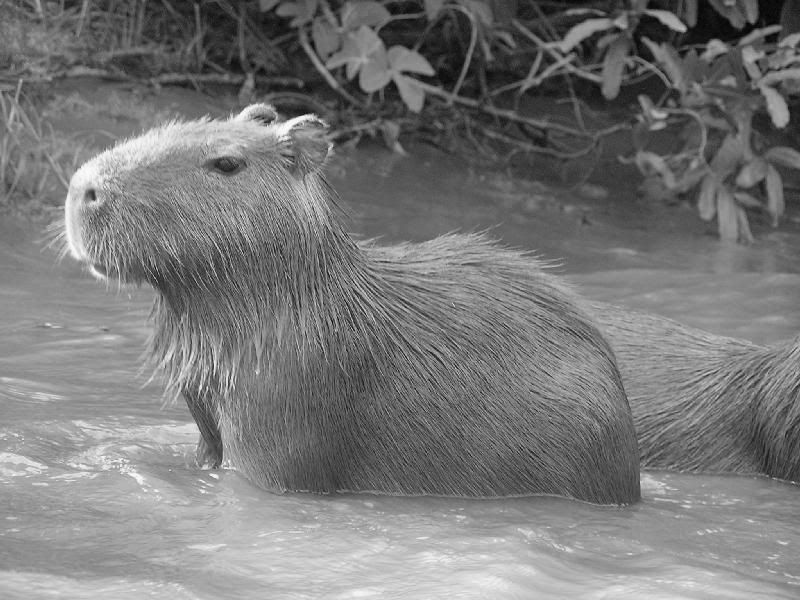

In [37]:
print('Original image:')
display_img(array)

Filtered image:


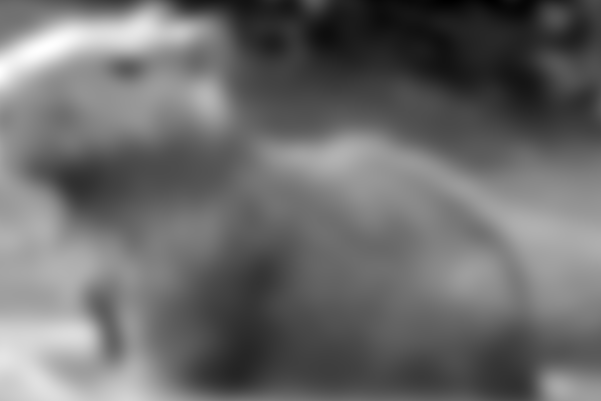

In [38]:
print('Filtered image:')
display_img(xx_filtered)